# Avocado Prices... The Reason Millennials Can't Buy Homes

**Group 36: Siddharth Balodi, Justin Gallant, Jackie Hagstrom, and Simon Lin**

## Introduction

Avocados. It’s hard to find another superfood that has as strong a chokehold on millennials. In the United States, avocado consumption rose from an average of 1.73 pounds per person in the 1980s to an average of 8 pounds per person in 2018, a 400% increase (Carman, 2019). However, avocados are known to be one of the pricier items in the produce aisle due, to their high cost of production, and trade and labor disputes between the United States and Michoacán, a region in Mexico the U.S. imports 87% of their avocados from (Cho et al., 2017).

In this project, we will employ a [dataset](https://www.kaggle.com/datasets/neuromusic/avocado-prices) from Kaggle, sourced from the Hass Avocado Board website in 2018. This dataset compiles weekly retail sales of Hass avocados per unit from retailers’ cash registers in multiple regions in the United States from years 2015 to 2018 (Kiggins, 2018). Our question is: **how do the average prices of conventional avocados across the U.S. change from 2015 to 2016?**

To answer this question, we will conduct hypothesis testing with a significance level of 0.05, using both bootstrapping and a theory-based approach.

## Methods and Results

### Setting Up the Workflow and Tidying Data

To begin our exploration of the data, we will first import required libraries into our project and set a random seed.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(infer)
library(broom)
library(digest)
library(dbplyr)
library(cowplot)

require(ggplot2)
require(gridExtra)

set.seed(2023)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

We will download the [dataset](https://www.kaggle.com/datasets/neuromusic/avocado-prices) (Kiggins, 2018) from the web and import it into our project.

In [2]:
# reading dataset from the web
avocado_data <- read_csv("https://raw.githubusercontent.com/anarchocoderism/stat-201-2023w1-group-36/main/avocado.csv")

print("Table 1.0 : Untidy Dataset")
head(avocado_data)

New names:
• `` -> `...1`
Rows: 18249 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): type, region
dbl  (11): ...1, AveragePrice, Total Volume, 4046, 4225, 4770, Total Bags, S...
date  (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1.0 : Untidy Dataset"


...1,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0,conventional,2015,Albany
5,2015-11-22,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0,conventional,2015,Albany


Now, we will tidy up this dataset so that it only contains our variables of interest (year, AveragePrice, region, type). We chose to include only conventional avocados because organic avocados tend to be more expensive. 

In [3]:
# tidying dataset
avocado_data_tidy <- avocado_data %>%
    select(year, AveragePrice, region, type) %>%

# filter data for regions representing all of the U.S., and conventional type of avocados
    filter(region == "TotalUS" & type == "conventional")

print("Table 1.1 : Tidy Dataset")
head(avocado_data_tidy)

[1] "Table 1.1 : Tidy Dataset"


year,AveragePrice,region,type
<dbl>,<dbl>,<chr>,<chr>
2015,0.95,TotalUS,conventional
2015,0.98,TotalUS,conventional
2015,0.93,TotalUS,conventional
2015,0.89,TotalUS,conventional
2015,0.99,TotalUS,conventional
2015,0.96,TotalUS,conventional


We will now separate the data into our two samples of interest: the sample of avocados sold in 2015, and the sample of avocados sold in 2016.

In [4]:
# filtering avocados by year
avocados_2015 <- avocado_data_tidy %>%
    filter(year == 2015) |>
    mutate(region = as.factor(region))

avocados_2016 <- avocado_data_tidy %>%
    filter(year == 2016) |>
    mutate(region = as.factor(region))

print("Table 1.2 : 2015 Data")
head(avocados_2015)

print("Table 1.3 : 2016 Data")
head(avocados_2016)

[1] "Table 1.2 : 2015 Data"


year,AveragePrice,region,type
<dbl>,<dbl>,<fct>,<chr>
2015,0.95,TotalUS,conventional
2015,0.98,TotalUS,conventional
2015,0.93,TotalUS,conventional
2015,0.89,TotalUS,conventional
2015,0.99,TotalUS,conventional
2015,0.96,TotalUS,conventional


[1] "Table 1.3 : 2016 Data"


year,AveragePrice,region,type
<dbl>,<dbl>,<fct>,<chr>
2016,1.00,TotalUS,conventional
2016,0.96,TotalUS,conventional
2016,0.98,TotalUS,conventional
2016,1.00,TotalUS,conventional
2016,1.21,TotalUS,conventional
2016,1.27,TotalUS,conventional


### Exploratory Data Analysis

In our exploratory data analysis, we are going to give an overview of the characteristics of our data, which will direct us in our hypothesis testing. 

##### Creating Sample Distribution for Mean Price in 2015

In [5]:
options(repr.plot.width = 8.25, repr.plot.height = 4)

# using ggplot to visualise sample distribution for 2015
sample_distribution_2015 <- avocados_2015 |>
    select(AveragePrice) |>
        ggplot() +
        geom_histogram(aes(x = AveragePrice), bins = 15, fill = "#D3D3D3", colour = "black") + 
        labs(x = "Average Price ($USD)", 
             y = "Count", 
             title = "Sample Distribution of Mean Avocado Prices\nAcross USA in 2015") +
        xlim(0.75,1.5) +
        ylim(0,25)

##### Creating Sample Distribution for Mean Price in 2016

In [6]:
options(repr.plot.width= 8.25, repr.plot.height= 4)

# using ggplot to visualise sample distribution for 2016
sample_distribution_2016 <- avocados_2016 |>
    select(AveragePrice) |>
        ggplot() +
        geom_histogram(aes(x = AveragePrice), bins = 15,  fill = "#D3D3D3", colour = "black") + 
        labs(x = "Average Price ($USD)", 
             y = "Count", 
             title = "Sample Distribution of Mean Avocado Prices\nAcross USA in 2016") +
        xlim(0.75,1.5) +
        ylim(0,25)

##### Displaying the Sample Distributions for Mean Price

[1] "Figure 2.0 : Sample Distributions for 2015 and 2016"


Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


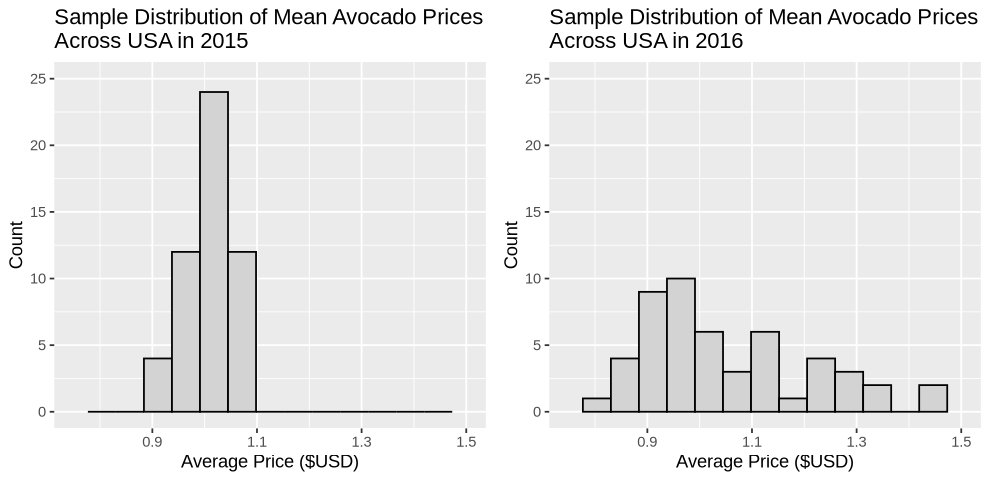

In [7]:
# displaying sample distributions
print("Figure 2.0 : Sample Distributions for 2015 and 2016")
grid.arrange(sample_distribution_2015, sample_distribution_2016, ncol = 2)

In 2015, the prices had a much smaller variance and a symmetric distribution, but in 2016 there was a much larger variance with a right-skewed distribution.

##### Boxplot Distribution for Mean Price in 2015

In [8]:
# using geom_boxplot to visualise 2015 data
boxplot_2015 <- avocados_2015 |>
    select(AveragePrice, year) |>
    mutate(year = as.factor(year)) |>
        ggplot() +
        geom_boxplot(aes(x = year, y = AveragePrice), fill = "#D3D3D3", colour = "black") + 
        labs(x = "Year", y = "Mean Avocado Price ($USD)", title = "Mean Avocado Prices across USA\nIn 2015") +
        ylim(0.75,1.5)

##### Boxplot Distribution for Mean Price in 2016

In [9]:
# using geom_boxplot to visualise 2016 data
boxplot_2016 <- avocados_2016 |>
    select(AveragePrice, year) |>
    mutate(year = as.factor(year)) |>
        ggplot() +
        geom_boxplot(aes(x = year, y = AveragePrice), fill = "#D3D3D3", colour = "black") +
        labs(x = "Year", y = "Mean Avocado Price ($USD)", title = "Mean Avocado Prices across USA\nIn 2016") +
        ylim(0.75,1.5)

##### Displaying the Boxplot Distributions for Mean Price

[1] "Figure 2.1 : Boxplot Distributions for 2015 and 2016"


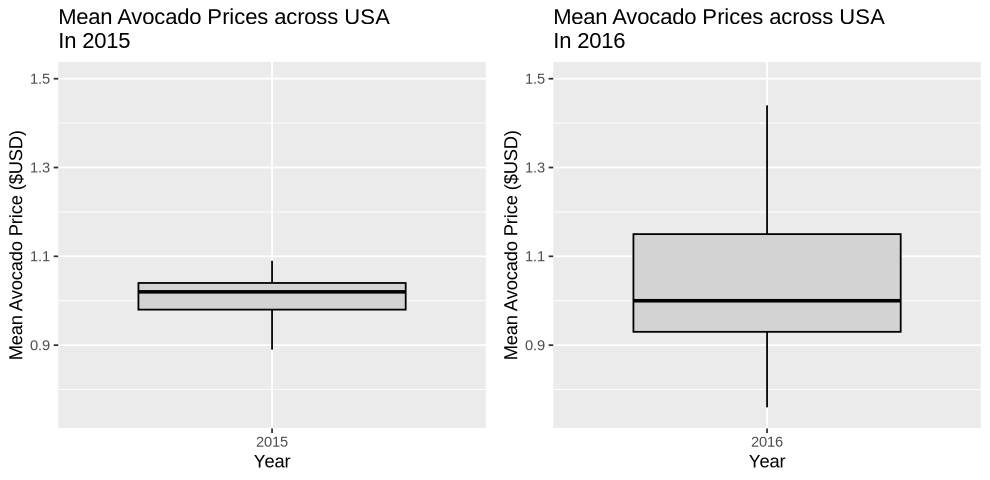

In [10]:
# displaying boxplot distributions
print("Figure 2.1 : Boxplot Distributions for 2015 and 2016")
grid.arrange(boxplot_2015, boxplot_2016, ncol = 2)

Through further examination with a boxplot, we see that in 2015, the prices had a much smaller variance, symmetric distribution, and an ordinary median. In 2016 there was a much larger variance, a right-skewed distribution, and an ordinary median.

### Calculating Test Statistics

We will calculate some relevant test statistics and display them in a tibble below.

In [11]:
# calculating test statistics for 2015
observed_mean_var_2015 <- avocados_2015 %>%
    summarize(mean_price_2015 =  mean(AveragePrice),
              var_2015 = var(AveragePrice),
              n_2015 = n())

# calculating test statistics for 2016
observed_mean_var_2016 <- avocados_2016 %>%
    summarize(mean_price_2016 = mean(AveragePrice),
              var_2016 = var(AveragePrice),
              n_2016 = n())

# combining tibbles with bind_cols and calculating difference in means (2016 - 2015)
total_observed_mean_var <- bind_cols(observed_mean_var_2015, observed_mean_var_2016) |>
    mutate(mean_difference = mean_price_2016 - mean_price_2015)

print("Table 3.0 : Observed Statistics")
total_observed_mean_var

[1] "Table 3.0 : Observed Statistics"


mean_price_2015,var_2015,n_2015,mean_price_2016,var_2016,n_2016,mean_difference
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
1.0125,0.002254412,52,1.046731,0.02679498,52,0.03423077


### Methods

Our report is trustworthy because our sample is a random, representative sample that includes retail data from various regions across the U.S. Focusing on conventional avocados between two consecutive years helps reduce the variation that may arise from adding organic avocados or sales from numerous years into our study. 

However, what we have so far is insufficient for making a conclusive statement regarding the changes in avocado prices between 2015 and 2016. Currently, we have a single sample taken from the population of all avocado sales in 2015 and 2016. To answer our research question, we will conduct a hypothesis test on the difference in means to assess whether the difference in average price between 2015 and 2016 represents a real difference between the two populations, or is the result of sampling variation.

##### Hypothesis Test

$H_{0}: \mu_{2016} -  \mu_{2015} = 0$

$H_{A}: \mu_{2016} -  \mu_{2015} > 0$

We will also create a confidence interval to determine the range of possible values the true difference in mean price will fall between.

We would expect avocado prices to increase according to the rate of inflation. Our findings could help predict how avocado prices will change in the current year. Our findings could lead to future studies researching the correlation between avocado price and weather events (e.g. drought), popularity on social media, or importing disputes in the U.S. Another possible question could be: what causes the difference between organic and conventional avocado prices?

### Bootstrapping Hypothesis Testing

Our first hypothesis test uses the bootstrap method. We will generate a simulation-based null distribution using the infer package, then calculate the corresponding p-value (the probability of obtaining a result at least as extreme as the observed test statistic).

In [12]:
# combine tidied data from 2015 and 2016 so they're in the same table
avocados_sample <- bind_rows(avocados_2015, avocados_2016) |>

# change data type of the year column so it can function as an explanatory variable in hypothesis testing
    mutate(year = as.factor(year))

print("Table 4.0 : Combined Tidy Data for 2015 and 2016")
head(avocados_sample)
tail(avocados_sample)

[1] "Table 4.0 : Combined Tidy Data for 2015 and 2016"


year,AveragePrice,region,type
<fct>,<dbl>,<fct>,<chr>
2015,0.95,TotalUS,conventional
2015,0.98,TotalUS,conventional
2015,0.93,TotalUS,conventional
2015,0.89,TotalUS,conventional
2015,0.99,TotalUS,conventional
2015,0.96,TotalUS,conventional


year,AveragePrice,region,type
<fct>,<dbl>,<fct>,<chr>
2016,0.76,TotalUS,conventional
2016,0.93,TotalUS,conventional
2016,0.95,TotalUS,conventional
2016,0.94,TotalUS,conventional
2016,0.93,TotalUS,conventional
2016,0.86,TotalUS,conventional


Here, we calculate the observed test statistic using the infer package to ensure it matches the value calculated in Table 3.0 (mean_difference).

In [13]:
# calculate observed test statistic using infer
obs_diff_mean <- avocados_sample |>
    specify(formula = AveragePrice ~ year) |>
    calculate(stat = "diff in means", order = c("2016", "2015"))

print("Table 4.1 : Observed Difference in Means")
obs_diff_mean

[1] "Table 4.1 : Observed Difference in Means"


stat
<dbl>
0.03423077


The null distribution is created by generating 5000 permutations of the sample, then calculating the test statistic for each replicate. Since this shuffles the variables 'year' and 'AveragePrice', the null distribution corresponds to our "hypothesized universe" where the response variable (AveragePrice) is **independent** of the explanatory variable (year). Again, our null hypothesis states the mean average price is the same in 2015 and 2016, and therefore the difference in means is zero.

In [14]:
null_distribution <- avocados_sample |>

# specify() allows us to create a formula for the relationship between "AveragePrice" and "year" variables
# AveragePrice = response variable, year = explanatory variable
    specify(formula = AveragePrice ~ year) |>

# "independence" tests whether AveragePrice values are independent of the variable that assigns them (year)
    hypothesize(null = "independence") |>

# generates 5000 replicates of "shuffled" datasets assuming the null hypothesis is true
    generate(reps = 5000, type = "permute") |>

# calculate test statistic for each shuffled replicate
    calculate(stat = "diff in means", order = c("2016", "2015"))

print("Table 4.2 : Permutation Test Statistics")
head(null_distribution)

[1] "Table 4.2 : Permutation Test Statistics"


replicate,stat
<int>,<dbl>
1,0.006923077
2,0.008076923
3,0.010000000
4,0.033461538
5,0.018076923
6,-0.010384615


Below is a visual representation of the null distribution. The red vertical line is the observed test statistic ($0.03423077$), the difference in our original two sample means (Table 4.1). The shaded red region is the p-value, which represents the simulated differences in means greater (more extreme) than our observed value under the null hypothesis.

[1] "Figure 4.0 : Null Distribution"


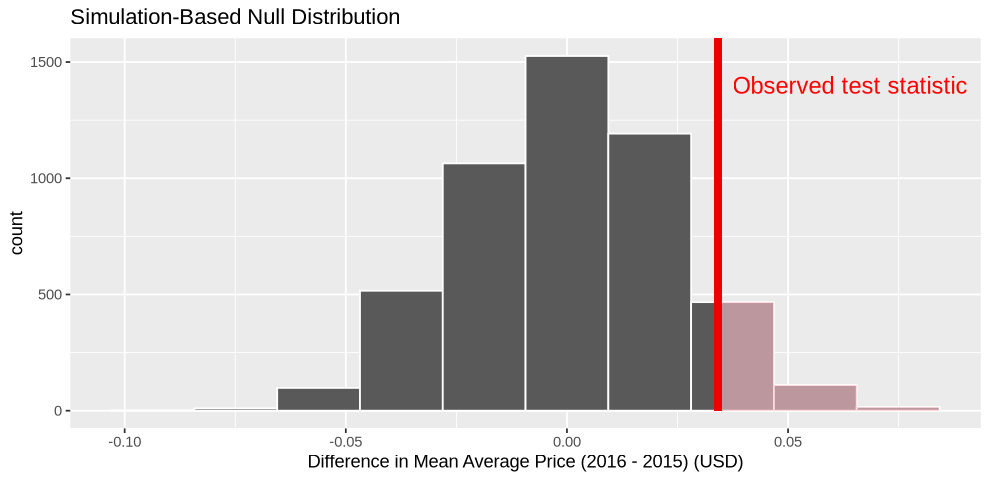

In [15]:
null_distribution_model <- null_distribution |>
    visualize(bins = 10) +

# one-tailed test where extreme values fall to the right of the observed difference in means
    shade_p_value(obs_stat = obs_diff_mean, direction = "right") +
    xlab("Difference in Mean Average Price (2016 - 2015) (USD)") +
    annotate("text", x = 0.064, y = 1400, label = "Observed test statistic", color="red", size=5)

print("Figure 4.0 : Null Distribution")
null_distribution_model

The p-value is generated below.

In [16]:
# calculating p-value using the get_p_value function
p_value <- null_distribution |>

# we set direction = "right" because more extreme values are those greater than obs_diff_mean
    get_p_value(obs_stat = obs_diff_mean, direction = "right")

print("Table 4.3 : P-Value")
p_value

[1] "Table 4.3 : P-Value"


p_value
<dbl>
0.0792


When comparing our p-value to the significance level, we see that:

$p = 0.0792$ , $\alpha = 0.05$.

$p > \alpha$.

Using the bootstrap method, there was a 7.92% probability of obtaining a value at least as extreme as the observed test statistic under the null hypothesis. This value is greater than the 5% significance level. As a result, we do not reject the null hypothesis.

### Bootstrapping Confidence Interval

We can also calculate a 95% confidence interval for the test statistic.

[1] "Table 4.4 : Bootstrap Confidence Interval"


lower_ci,upper_ci
<dbl>,<dbl>
-0.00966294,0.08143338


[1] "Figure 4.1 : Bootstrap Distribution With 95% Confidence Interval"


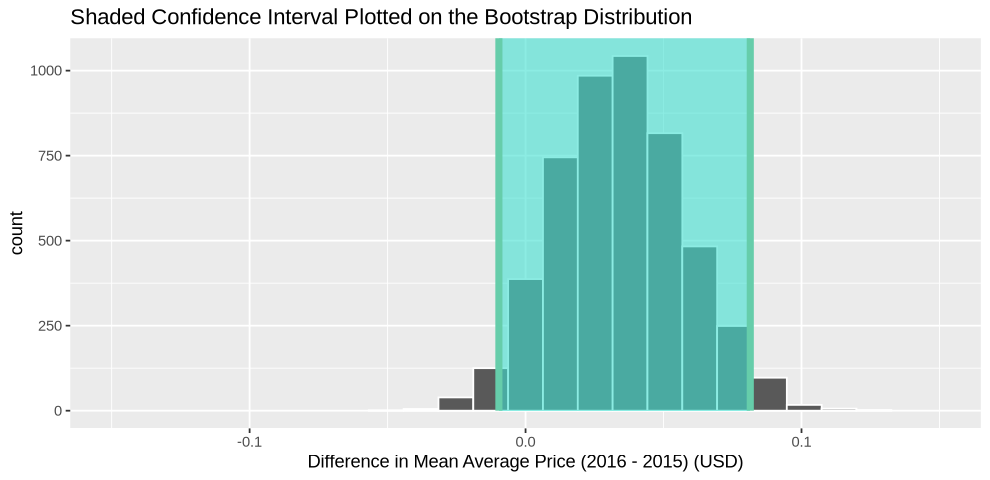

In [17]:
# the following code is similar to that for the null distribution
bootstrap_distribution <- avocados_sample |>
  specify(formula = AveragePrice ~ year) |>

# remove the hypothesize() function
# change "permute" to "bootstrap" to perform sampling WITH replacement
  generate(reps = 5000, type = "bootstrap") |>
  calculate(stat = "diff in means", order = c("2016", "2015"))

# generate a 95% confidence interval using the percentile method
percentile_ci <- bootstrap_distribution |>
  get_confidence_interval(level = 0.95, type = "percentile")

print("Table 4.4 : Bootstrap Confidence Interval")
percentile_ci

# visualization of confidence interval on the bootstrap distribution
ci_visualization <- visualize(bootstrap_distribution) + 
  shade_confidence_interval(endpoints = percentile_ci) +
  labs(title = "Shaded Confidence Interval Plotted on the Bootstrap Distribution",
       x = "Difference in Mean Average Price (2016 - 2015) (USD)") +
  xlim(c(-0.15,0.15))

print("Figure 4.1 : Bootstrap Distribution With 95% Confidence Interval")
ci_visualization

Given this CI, we are 95% confident that the true population parameter, the difference in means, is between $-0.00966294$ and $	0.08143338$.

### Asymptotic Hypothesis Testing

Next, we conduct a theory-based hypothesis test using the hypothesis test declared above. Since we only have access to a sample from the population, we will use a t-test.

First, let us calculate the t-score for the difference of means. This calculation centers and scales the point estimate so that it lies on the t-distribution.

In [18]:
# first get variables to make code cleaner
mean_2016 <- total_observed_mean_var$mean_price_2016
mean_2015 <- total_observed_mean_var$mean_price_2015

var_2016 <- total_observed_mean_var$var_2016 # we will stick with variance - if we use sd we will have to square it again anyway
var_2015 <- total_observed_mean_var$var_2015

n <- 52 # since we are using the same number of observations for both equations (see Table 3.0)

# now calculate t-score
t_score <- (mean_2016 - mean_2015)/sqrt((var_2016)/n + (var_2015)/n)

print("Table 5.0 : T-score")
tibble(t_score)

[1] "Table 5.0 : T-score"


t_score
<dbl>
1.448271


Let us now calculate the degrees of freedom for our distribution using the formula for degrees of freedom for difference of means.

In [19]:
# calculating degrees of freedom for our distribution
df_diff_means <- (((var_2016)/n + (var_2015)/n)^2)/((var_2016^2)/((n^2)*(n-1)) + (var_2015^2)/((n^2)*(n-1)))

print("Table 5.1 : Degrees of Freedom")
tibble(df_diff_means)

[1] "Table 5.1 : Degrees of Freedom"


df_diff_means
<dbl>
59.52151


Using this value for degrees of freedom, let us calculate the probability of getting a score equal to or larger than **t_score** on the t-distribution.

In [20]:
# Using pt() to calulate p-value
p_value_theoretical <- pt(t_score, df_diff_means, lower.tail = FALSE)

print("Table 5.2 : Theoretical P-Value")
tibble(p_value_theoretical)

[1] "Table 5.2 : Theoretical P-Value"


p_value_theoretical
<dbl>
0.07639443


We can also use R's *t.test* method to confirm these results.

In [21]:
# using t.test() and tidy() to get t.test results
avocados_asymptotic <- t.test(x = avocados_2016$AveragePrice, y = avocados_2015$AveragePrice, mu = 0,
                              alternative = "g", conf.level = 0.95) %>%
    tidy()

print("Table 5.3 : t.test Results")
avocados_asymptotic

[1] "Table 5.3 : t.test Results"


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.03423077,1.046731,1.0125,1.448271,0.07639443,59.52151,-0.005261021,Inf,Welch Two Sample t-test,greater


When comparing our p-value to the significance level, we see that:

$p = 0.07639443$ , $\alpha = 0.05$.

$p > \alpha$.

There was a 7.64% probability of obtaining a value at least as extreme as the observed test statistic under the null hypothesis. This value is greater than the 5% significance level. As a result, we do not reject the null hypothesis.

Let us now visualize our t-score along the t-distribution. The red region on the graph represents the range of t-scores for which we would reject the null hypothesis, and the dotted line represents our observed t-score.

[1] "Figure 5.0 : T-Distribution"


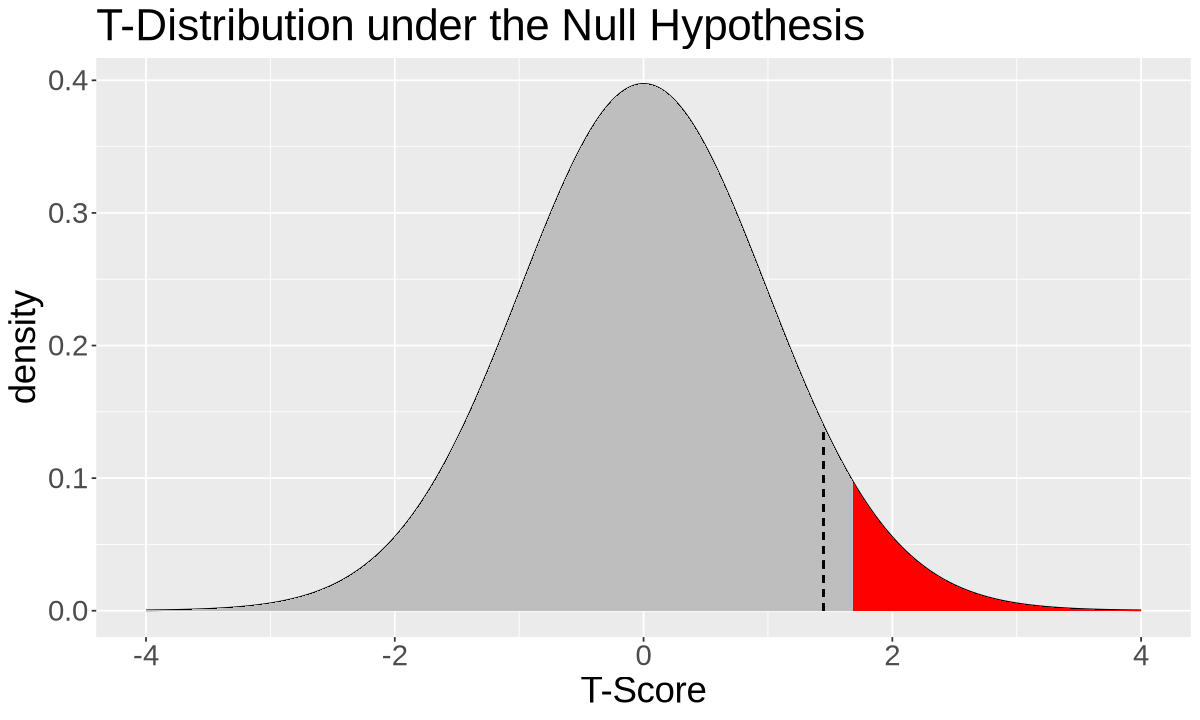

In [22]:
options(repr.plot.width = 10, repr.plot.height = 6)

# visualising t-distribution using ggplot
t_dist_graph <-
    tibble(t = seq(-4, 4, 0.01), density = dt(t, df = df_diff_means)) %>% 
    ggplot() + geom_line(aes(t, density)) +
    geom_ribbon(mapping = aes(x = t, ymax = density, ymin = 0), alpha = 1, fill = "grey")  +
    geom_ribbon(. %>% filter(t > qt(0.95, df_diff_means)),
                mapping = aes(x = t, ymax = density, ymin = 0), alpha = 1, fill = "red") + 
    geom_segment(aes(x = t_score, 
                     y = 0, 
                     xend= t_score,
                     yend = dt(t_score, df_diff_means)),
                 colour="black", linetype = 'dashed') + 
    theme(text = element_text(size=22)) + 
    xlab("T-Score") +
    ggtitle("T-Distribution under the Null Hypothesis")

print("Figure 5.0 : T-Distribution")
t_dist_graph

### Asymptotic Confidence Interval

We can also calculate a confidence interval for the test statistic using the formula:
$$CI = (x_{2016} - x_{2015}) \cdot t S_p \sqrt{\frac{1}{n_{2016}} + \frac{1}{n_{2015}}}$$Where $S_p$ is the pooled sample standard deviation: $$S_p = \sqrt{\frac{(n_{2016} - 1)s^2_{2016} + (n_{2015} - 1)s^2_{2015}}{n_{2016} + n_{2015} - 2}}$$

In [23]:
sp <- sqrt(((52-1)*sd(avocados_2016$AveragePrice)^2 + (52-1)*sd(avocados_2015$AveragePrice)^2)/(52+52-2))

print("Table 5.4 : Pooled Sample Standard Deviation")
tibble(sp)

[1] "Table 5.4 : Pooled Sample Standard Deviation"


sp
<dbl>
0.1205185


In [26]:
# calculating the CI
t_lower_confidence_interval <- (mean(avocados_2016$AveragePrice) - mean(avocados_2015$AveragePrice)) - (t_score * sp * sqrt(1/52 + 1/52))
t_upper_confidence_interval <- (mean(avocados_2016$AveragePrice) - mean(avocados_2015$AveragePrice)) + (t_score * sp * sqrt(1/52 + 1/52))

# creating a tibble
t_confidence_interval <- tibble(lower_ci = t_lower_confidence_interval,
                                upper_ci = t_upper_confidence_interval)

print("Table 5.5 : T-test Confidence Interval")
t_confidence_interval

[1] "Table 5.5 : T-test Confidence Interval"


lower_ci,upper_ci
<dbl>,<dbl>
-6.938894e-18,0.06846154


Given this CI, we are 95% confident that the true population parameter, the difference in means, is between $-6.94 \times 10^{-18}$ and $0.0685$.

### Results

In both tests, we failed to reject the null hypothesis.

$$\alpha = 0.05$$$$p_{bootstrap} = 0.0792$$$$p_{t} = 0.0764$$

We also found the respective methods' confidence intervals:

$$CI_{bootstrap} = [−0.00966,0.0814]$$
$$CI_{t} = [-6.94\times 10^{-18},0.0685]$$

## Discussion

In our investigation of avocado prices across the United States between 2015 and 2016, we ran two hypothesis tests to compare the mean prices of avocados in the two consecutive years. Our goal was to assess whether there was a significant difference in average prices and to interpret the implications of our findings.

##### Bootstrap Method Results

The bootstrap method generated a p-value of $0.0792$, failing to reject the null hypothesis ($H_{0}$) at a significance level of $\alpha = 0.05$. The 95% confidence interval for the difference in means ranged from $-0.00966$ to $0.0814$, suggesting a range that includes zero.

##### Asymptotic (t-test) Method Results

Similarly, the t-test produced a p-value of $0.0764$, also failing to reject $H_{0}$ at $\alpha = 0.05$. The 95% confidence interval from the t-distribution was $[-6.94 \times 10^{-18}, 0.0685]$, again indicating a range that includes zero.

##### Comparison of Results

When comparing our results from bootstrapping and asymptotics, we see that both methods yield fairly close results, which can be attributed to the fact that we used sufficiently large sample sizes. The results are trustworthy in the sense that they behave predictably, but they also contain the possibility of Type II error, which is apparent upon examining the confidence intervals.

##### Inconsistency in Results

Both methods that we use lead to the same conclusion: a failure to reject the null hypothesis. According to the CI endpoints, the null hypothesis value (zero) is included in the confidence interval for both hypothesis tests. Therefore, zero is a plausible value for the population parameter, which supports our hypothesis test findings that 2015 and 2016 average prices aren't truly different. However, most of the values in the confidence intervals lie above 0, which hints at a positive difference in means, suggesting that the average avocado price in 2016 may be slightly higher than in 2015. This inconsistency raises questions about the robustness of our findings and the potential for a Type II error, where we may have overlooked a true difference.

##### Interpretation

Our study, while failing to demonstrate a statistically significant change in avocado prices, provides valuable insights into the challenges of hypothesis testing. The lack of significance might indicate a true absence of change, or it could be a result of the limitations of our sample size and the inherent variability in avocado prices. 

Our findings have important ramifications for consumers, businesses, and legislators who depend on precise food price forecasts. If avocado prices are rising subtly, it is critical to comprehend the factors that are causing this shift. Future studies could examine outside variables that could affect avocado prices, such as climatic events, social media trends, or international trade disputes.

##### Future Questions

*Exploring Type II Error* - Given the inconsistency of our results, future research could dive deeper into underdstanding why our study encounters a potential Type II error. Analysing a larger dataset or using different methodology might uncover differences that were not as apparent in our research.

*External Influences on Avocado Prices* - Investigating the correlation between avocado prices and external factors such as weather events, social media trends, or economic conditions could provide a more comprehensive understanding of price dynamics.


Despite the lack of a statistically significant difference in the average price of avocados between 2015 and 2016, our study's nuanced confidence intervals and the possibility of a Type II error point to potential directions for further investigation. In addition to the agricultural sector, consumers and policymakers alike must comprehend the dynamics of avocado prices in order to effectively navigate the complex food market.

## References

Carman, H. F. (2019). The story behind avocados’ rise to prominence in the United States. Agricultural and resource economics (ARE) update, 22(5), 9–11.

Cho, K., Goldstein, B., Gounaridis, D., & Newell, J. P. (2021). Where does your guacamole come from? Detecting deforestation associated with the export of avocados from Mexico to the United States. Journal of Environmental Management, 278, 111482. https://doi.org/10.1016/j.jenvman.2020.111482

Kiggins, J. (2018). Avocado Prices. www.kaggle.com. 
https://www.kaggle.com/datasets/neuromusic/avocado-prices